In [1]:
import sys
from pathlib import Path
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
pbp_plays_path = PROCESSED_DIR / "pbp_plays.parquet"
fourth_path = PROCESSED_DIR / "fourth_down.parquet"

if not pbp_plays_path.exists():
    raise FileNotFoundError(f"Missing {pbp_plays_path} (run Notebook 01).")
if not fourth_path.exists():
    raise FileNotFoundError(f"Missing {fourth_path} (run Notebook 01).")

pbp = pd.read_parquet(pbp_plays_path)
fourth = pd.read_parquet(fourth_path)

print("pbp:", pbp.shape)
print("fourth:", fourth.shape)

pbp: (124981, 397)
fourth: (13041, 398)


In [2]:
def as_bool(s):
    if s is None:
        return None
    if str(s.dtype) in ("bool", "boolean"):
        return s.fillna(False)
    return s.fillna(0).astype(int).astype(bool)

def ensure_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def kick_distance_from_yardline100(y):
    return y + 17

def mirror_yardline_100(y):
    return np.clip(100 - y, 1, 99)

def show_cols_like(df, patterns, name):
    cols = df.columns.tolist()
    out = []
    for c in cols:
        cl = c.lower()
        if any(p in cl for p in patterns):
            out.append(c)
    print(f"\n{name} columns matching {patterns}:")
    print(out)

show_cols_like(pbp, ["fg","field_goal"], "pbp")
show_cols_like(fourth, ["fg","field_goal"], "fourth")


pbp columns matching ['fg', 'field_goal']:
['field_goal_result', 'opp_fg_prob', 'fg_prob', 'field_goal_attempt']

fourth columns matching ['fg', 'field_goal']:
['field_goal_result', 'opp_fg_prob', 'fg_prob', 'field_goal_attempt']


In [3]:
# merge selected columns from pbp if missing in fourth
candidate = [
    "home_score","away_score","home_timeouts_remaining","away_timeouts_remaining",
    "punt_attempt","field_goal_attempt","pass_attempt","rush_attempt",
    "first_down","success","desc","play_type","game_seconds_remaining","qtr",
    "home_team","away_team","posteam","defteam"
]
missing = [c for c in candidate if (c not in fourth.columns and c in pbp.columns)]
if missing:
    fourth = fourth.merge(pbp[["game_id","play_id"] + missing], on=["game_id","play_id"], how="left")
    print("Merged from pbp into fourth:", missing)

fourth = ensure_numeric(fourth, ["ydstogo","yardline_100","game_seconds_remaining","qtr","home_score","away_score"])
fourth["kick_distance"] = kick_distance_from_yardline100(fourth["yardline_100"])

fourth[["decision","posteam","ydstogo","yardline_100","kick_distance"]].head()

,decision,posteam,ydstogo,yardline_100,kick_distance
0,punt,NYJ,15.0,64.0,81.0
1,punt,BAL,1.0,51.0,68.0
2,punt,NYJ,9.0,82.0,99.0
3,punt,BAL,9.0,65.0,82.0
4,field_goal,BAL,3.0,6.0,23.0


## Win Probability model (home win)

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# outcomes from final scores
games = (
    pbp.groupby("game_id", as_index=False)
       .agg(home_team=("home_team","first"),
            away_team=("away_team","first"),
            home_score_final=("home_score","max"),
            away_score_final=("away_score","max"))
)
games["home_win"] = (games["home_score_final"] > games["away_score_final"]).astype(int)

df = pbp.merge(games[["game_id","home_win"]], on="game_id", how="left").copy()
df = ensure_numeric(df, ["down","ydstogo","yardline_100","qtr","game_seconds_remaining","home_score","away_score",
                         "home_timeouts_remaining","away_timeouts_remaining"])

df["is_home_possession"] = (df["posteam"] == df["home_team"]).astype(int)
df["score_diff_home"] = df["home_score"].fillna(0) - df["away_score"].fillna(0)
df["time_remaining"] = df["game_seconds_remaining"].fillna(0).clip(lower=0)
df["home_to"] = df.get("home_timeouts_remaining", pd.Series(np.nan, index=df.index)).fillna(3).clip(0,3)
df["away_to"] = df.get("away_timeouts_remaining", pd.Series(np.nan, index=df.index)).fillna(3).clip(0,3)

df = df.dropna(subset=["home_win","down","ydstogo","yardline_100","qtr","time_remaining","posteam"]).copy()

NUM_FEATURES = ["down","ydstogo","yardline_100","qtr","time_remaining","score_diff_home","home_to","away_to","is_home_possession"]
num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())])
wp_model = Pipeline([
    ("pre", ColumnTransformer([("num", num_pipe, NUM_FEATURES)], remainder="drop")),
    ("clf", LogisticRegression(max_iter=300))
])

# train split by game
rng = np.random.default_rng(7)
gids = df["game_id"].unique()
rng.shuffle(gids)
split = int(0.8 * len(gids))
train_g = set(gids[:split])
train = df[df["game_id"].isin(train_g)].copy()

wp_model.fit(train, train["home_win"].astype(int).values)
print("WP trained on plays:", len(train))

WP trained on plays: 100116


## Conversion model (go-for-it)

In [5]:
from sklearn.metrics import roc_auc_score

go = fourth[fourth["decision"] == "go_for_it"].copy()

# label conversion
if "first_down" in go.columns and go["first_down"].notna().any():
    y_conv = as_bool(go["first_down"]).astype(int).values
elif "success" in go.columns and go["success"].notna().any():
    y_conv = pd.to_numeric(go["success"], errors="coerce").fillna(0).astype(int).values
else:
    raise RuntimeError("Need conversion label: first_down or success")

conv_feats = ["ydstogo","yardline_100","game_seconds_remaining","qtr"]
go = ensure_numeric(go, conv_feats)
X_conv = go[conv_feats].copy()

conv_model = Pipeline([
    ("pre", ColumnTransformer([("num", num_pipe, conv_feats)], remainder="drop")),
    ("clf", LogisticRegression(max_iter=300))
])
conv_model.fit(X_conv, y_conv)

p_conv = conv_model.predict_proba(X_conv)[:,1]
print("Go samples:", len(go), "Conv rate:", y_conv.mean().round(3), "AUC:", roc_auc_score(y_conv, p_conv).round(3))

Go samples: 2429 Conv rate: 0.533 AUC: 0.684


## Field goal model (NO fg_result dependency)

In [6]:
def build_fg_made_label(fg_df, pbp_df):
    """
    Returns a copy of fg_df with a boolean/int column 'fg_made' created.
    Never assumes fg_result exists; tries multiple sources, then falls back to desc parsing.
    """
    fg_df = fg_df.copy()

    # 1) Check if fg_result-like exists already in fg_df
    fg_candidates = [c for c in fg_df.columns if c.lower() in ("fg_result", "field_goal_result", "field_goal_outcome")]
    if fg_candidates:
        col = fg_candidates[0]
        vals = fg_df[col].astype(str).str.lower()
        fg_df["fg_made"] = vals.eq("made").astype(int)
        return fg_df

    # 2) Try merging a result column from pbp (if any exists)
    pbp_candidates = [c for c in pbp_df.columns if c.lower() in ("fg_result", "field_goal_result", "field_goal_outcome")]
    if pbp_candidates:
        src = pbp_candidates[0]
        merged = fg_df.merge(pbp_df[["game_id","play_id", src]], on=["game_id","play_id"], how="left")
        vals = merged[src].astype(str).str.lower()
        merged["fg_made"] = vals.eq("made").astype(int)
        return merged.drop(columns=[src])

    # 3) Fallback: parse description
    if "desc" not in fg_df.columns:
        raise RuntimeError("Cannot label FG makes: no fg_result-like columns and no 'desc' column.")

    desc = fg_df["desc"].astype(str)
    made = desc.str.contains(r"\bGOOD\b", case=False, na=False)
    missed = desc.str.contains(r"NO GOOD|NOGOOD|MISS|MISSED", case=False, na=False)

    fg_df["fg_made"] = np.where(made, 1, np.where(missed, 0, np.nan))
    return fg_df

fg = fourth[fourth["decision"] == "field_goal"].copy()
fg_labeled = build_fg_made_label(fg, pbp)

# keep only rows we could label
fg_labeled = fg_labeled.dropna(subset=["fg_made","kick_distance"]).copy()
fg_labeled["fg_made"] = fg_labeled["fg_made"].astype(int)

X_fg = fg_labeled[["kick_distance"]].copy()
y_fg = fg_labeled["fg_made"].values

fg_model = Pipeline([
    ("pre", ColumnTransformer([("num", num_pipe, ["kick_distance"])], remainder="drop")),
    ("clf", LogisticRegression(max_iter=300))
])
fg_model.fit(X_fg, y_fg)

print("FG labeled samples:", len(fg_labeled), "Make rate:", y_fg.mean().round(3))

FG labeled samples: 3107 Make rate: 0.857


## Punt map

In [8]:
# --- Cell 7 FIXED: build punt LOS → opponent start map (dtype-safe) ---

pbp_sorted = pbp.sort_values(["game_id","play_id"]).copy()
pbp_sorted["posteam_next"] = pbp_sorted.groupby("game_id")["posteam"].shift(-1)
pbp_sorted["yardline_100_next"] = pbp_sorted.groupby("game_id")["yardline_100"].shift(-1)

# SAFE boolean conversion
punt_att = as_bool(pbp_sorted.get("punt_attempt"))

punt_rows = pbp_sorted[
    (punt_att) &
    (pbp_sorted["down"] == 4) &
    pbp_sorted["posteam"].notna() &
    pbp_sorted["posteam_next"].notna() &
    pbp_sorted["yardline_100"].notna() &
    pbp_sorted["yardline_100_next"].notna()
].copy()

punt_rows["los"] = pd.to_numeric(punt_rows["yardline_100"], errors="coerce")
punt_rows["opp_start"] = pd.to_numeric(punt_rows["yardline_100_next"], errors="coerce")

punt_rows = punt_rows[
    punt_rows["los"].between(1, 99) &
    punt_rows["opp_start"].between(1, 99)
]

# Bin LOS every 5 yards
punt_rows["los_bin"] = (np.floor(punt_rows["los"] / 5) * 5).astype(int)

punt_map = (
    punt_rows
    .groupby("los_bin", as_index=False)["opp_start"]
    .mean()
    .rename(columns={"opp_start": "exp_opp_start"})
)

def expected_punt_opp_start(los):
    if pd.isna(los):
        return 75.0
    b = int(np.clip(np.floor(los / 5) * 5, 0, 95))
    row = punt_map[punt_map["los_bin"] == b]
    if len(row):
        return float(row["exp_opp_start"].iloc[0])
    # fallback: nearest bin
    j = int(np.argmin(np.abs(punt_map["los_bin"].values - b)))
    return float(punt_map["exp_opp_start"].iloc[j])

print("Punt samples:", len(punt_rows))
punt_map.head()

Punt samples: 6760


,los_bin,exp_opp_start
0,25,69.000000
1,30,82.333336
2,35,86.450706
3,40,88.315216
4,45,86.981094


In [9]:
fd = fourth.copy()

fd["is_home_possession"] = (fd["posteam"] == fd["home_team"]).astype(int)
fd["score_diff_home"] = fd["home_score"].fillna(0) - fd["away_score"].fillna(0)
fd["time_remaining"] = fd["game_seconds_remaining"].fillna(0).clip(lower=0)
fd["home_to"] = fd.get("home_timeouts_remaining", pd.Series(np.nan, index=fd.index)).fillna(3).clip(0,3)
fd["away_to"] = fd.get("away_timeouts_remaining", pd.Series(np.nan, index=fd.index)).fillna(3).clip(0,3)

fd["p_home_win_base"] = wp_model.predict_proba(fd)[:, 1]

fd["p_convert"] = np.nan
m_go = fd["decision"] == "go_for_it"
if m_go.any():
    fd.loc[m_go, "p_convert"] = conv_model.predict_proba(fd.loc[m_go, conv_feats])[:, 1]

fd["p_fg_make"] = np.nan
m_fg = fd["decision"] == "field_goal"
if m_fg.any():
    # use the trained model directly; it doesn't need fg_result columns now
    fd.loc[m_fg, "p_fg_make"] = fg_model.predict_proba(fd.loc[m_fg, ["kick_distance"]])[:, 1]

fd[["decision","p_home_win_base","p_convert","p_fg_make"]].head(10)

,decision,p_home_win_base,p_convert,p_fg_make
0,punt,4.383149e-17,NaN,NaN
1,punt,4.171867e-17,NaN,NaN
2,punt,4.427072e-17,NaN,NaN
3,punt,4.443781e-17,NaN,NaN
4,field_goal,5.150843e-17,NaN,0.973675
5,punt,4.697974e-17,NaN,NaN
6,punt,3.541863e-17,NaN,NaN
7,field_goal,4.331547e-17,NaN,0.824483
8,punt,4.213369e-17,NaN,NaN
9,punt,4.546314e-17,NaN,NaN


In [10]:
def swap_possession(df_state):
    out = df_state.copy()
    out["posteam"], out["defteam"] = df_state["defteam"], df_state["posteam"]
    out["is_home_possession"] = (out["posteam"] == out["home_team"]).astype(int)
    return out

base = fd.copy()

# go success
go_succ = base.copy()
go_succ["yardline_100"] = (go_succ["yardline_100"] - go_succ["ydstogo"]).clip(1, 99)
go_succ["down"] = 1
go_succ["ydstogo"] = 10

# go fail
go_fail = base.copy()
go_fail["yardline_100"] = mirror_yardline_100(go_fail["yardline_100"])
go_fail["down"] = 1
go_fail["ydstogo"] = 10
go_fail = swap_possession(go_fail)

# punt
punt_state = base.copy()
punt_state["yardline_100"] = punt_state["yardline_100"].apply(expected_punt_opp_start)
punt_state["down"] = 1
punt_state["ydstogo"] = 10
punt_state = swap_possession(punt_state)

# fg made
fg_made = base.copy()
is_home_kick = fg_made["posteam"] == fg_made["home_team"]
fg_made.loc[is_home_kick, "home_score"] = fg_made.loc[is_home_kick, "home_score"] + 3
fg_made.loc[~is_home_kick, "away_score"] = fg_made.loc[~is_home_kick, "away_score"] + 3
fg_made["score_diff_home"] = fg_made["home_score"].fillna(0) - fg_made["away_score"].fillna(0)
fg_made["yardline_100"] = 75.0
fg_made["down"] = 1
fg_made["ydstogo"] = 10
fg_made = swap_possession(fg_made)

# fg miss
fg_miss = base.copy()
fg_miss["yardline_100"] = mirror_yardline_100(fg_miss["yardline_100"])
fg_miss["down"] = 1
fg_miss["ydstogo"] = 10
fg_miss = swap_possession(fg_miss)

# score with WP model
p_home_go_succ = wp_model.predict_proba(go_succ)[:, 1]
p_home_go_fail = wp_model.predict_proba(go_fail)[:, 1]
p_home_punt    = wp_model.predict_proba(punt_state)[:, 1]
p_home_fg_made = wp_model.predict_proba(fg_made)[:, 1]
p_home_fg_miss = wp_model.predict_proba(fg_miss)[:, 1]

pconv = fd["p_convert"].fillna(0.5).values
pfg   = fd["p_fg_make"].fillna(0.5).values

fd["p_home_win_go"]   = pconv * p_home_go_succ + (1 - pconv) * p_home_go_fail
fd["p_home_win_punt"] = p_home_punt
fd["p_home_win_fg"]   = pfg * p_home_fg_made + (1 - pfg) * p_home_fg_miss

# posteam perspective
is_home = (fd["posteam"] == fd["home_team"]).values
fd["p_posteam_win_go"]   = np.where(is_home, fd["p_home_win_go"],   1 - fd["p_home_win_go"])
fd["p_posteam_win_punt"] = np.where(is_home, fd["p_home_win_punt"], 1 - fd["p_home_win_punt"])
fd["p_posteam_win_fg"]   = np.where(is_home, fd["p_home_win_fg"],   1 - fd["p_home_win_fg"])
fd["p_posteam_win_base"] = np.where(is_home, fd["p_home_win_base"], 1 - fd["p_home_win_base"])

fd["best_option"] = fd[["p_posteam_win_go","p_posteam_win_punt","p_posteam_win_fg"]].idxmax(axis=1)
fd["best_option"] = fd["best_option"].str.replace("p_posteam_win_","")

decision_map = {"go_for_it":"go", "punt":"punt", "field_goal":"fg"}
fd["decision_simple"] = fd["decision"].map(decision_map)

col_map = {"go":"p_posteam_win_go", "punt":"p_posteam_win_punt", "fg":"p_posteam_win_fg"}
actual_cols = fd["decision_simple"].map(col_map)

fd["p_actual"] = [fd.loc[i, c] if isinstance(c, str) else np.nan for i, c in enumerate(actual_cols)]
fd["p_best"] = fd[["p_posteam_win_go","p_posteam_win_punt","p_posteam_win_fg"]].max(axis=1)
fd["decision_cost"] = (fd["p_best"] - fd["p_actual"]).clip(lower=0)

fd[["posteam","decision_simple","best_option","p_actual","p_best","decision_cost"]].head(10)

,posteam,decision_simple,best_option,p_actual,p_best,decision_cost
0,NYJ,punt,fg,3.693949e-17,3.404855e-14,3.401161e-14
1,BAL,punt,go,1.000000e+00,1.000000e+00,0.000000e+00
2,NYJ,punt,fg,4.224172e-17,3.730114e-14,3.725890e-14
3,BAL,punt,go,1.000000e+00,1.000000e+00,0.000000e+00
4,BAL,fg,go,1.000000e+00,1.000000e+00,0.000000e+00
5,NYJ,punt,fg,4.364817e-17,3.992146e-14,3.987781e-14
6,BAL,punt,go,1.000000e+00,1.000000e+00,0.000000e+00
7,NYJ,fg,fg,5.404945e-14,5.404945e-14,0.000000e+00
8,BAL,punt,go,1.000000e+00,1.000000e+00,0.000000e+00
9,NYJ,punt,fg,3.927898e-17,3.550600e-14,3.546672e-14


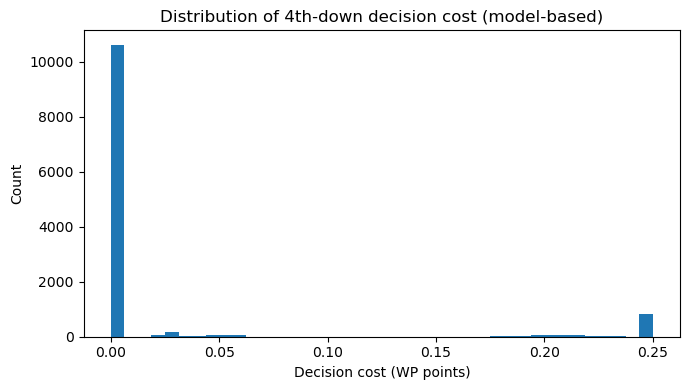

,season,week,posteam,qtr,game_seconds_remaining,ydstogo,yardline_100,decision_simple,best_option,decision_cost,desc
7587,2023,14,MIA,4.0,376.0,15.0,58.0,punt,fg,0.474623,"(6:16) 16-J.Bailey punts 47 yards to TEN 11, C..."
11031,2024,10,WAS,4.0,858.0,26.0,62.0,punt,fg,0.474139,"(14:18) 10-T.Way punts 49 yards to PIT 13, Cen..."
8479,2023,18,SF,4.0,476.0,4.0,52.0,punt,fg,0.473921,(7:56) 18-M.Wishnowsky punts 36 yards to LA 16...
8466,2023,18,LAC,4.0,820.0,7.0,55.0,punt,fg,0.473918,"(13:40) 16-J.Scott punts 40 yards to KC 15, Ce..."
2135,2022,10,CHI,4.0,821.0,5.0,74.0,punt,fg,0.473897,"(13:41) 16-T.Gill punts 39 yards to DET 35, Ce..."
170,2022,1,TEN,4.0,876.0,3.0,79.0,punt,fg,0.473850,(14:36) 4-R.Stonehouse punts 66 yards to NYG 1...
7588,2023,14,MIA,4.0,144.0,2.0,67.0,punt,fg,0.473715,"(2:24) 16-J.Bailey punts 45 yards to TEN 22, C..."
4473,2023,1,DEN,4.0,314.0,3.0,68.0,punt,fg,0.473437,"(5:14) 9-R.Dixon punts 37 yards to LV 31, Cent..."
11141,2024,11,CHI,4.0,267.0,8.0,54.0,punt,fg,0.473374,"(4:27) 19-T.Taylor punts 48 yards to GB 6, Cen..."
412,2022,2,CLE,4.0,254.0,26.0,50.0,punt,fg,0.473146,"(4:14) 13-C.Bojorquez punts 42 yards to NYJ 8,..."


In [11]:
plt.figure(figsize=(7,4))
plt.hist(fd["decision_cost"].dropna().clip(0,0.25), bins=40)
plt.xlabel("Decision cost (WP points)")
plt.ylabel("Count")
plt.title("Distribution of 4th-down decision cost (model-based)")
plt.tight_layout()
plt.show()

top = fd.sort_values("decision_cost", ascending=False).head(15)[
    ["season","week","posteam","qtr","game_seconds_remaining","ydstogo","yardline_100",
     "decision_simple","best_option","decision_cost","desc"]
]
top

In [12]:
out_cols = [
    "season","week","game_id","play_id","posteam","defteam","home_team","away_team",
    "qtr","game_seconds_remaining","ydstogo","yardline_100","kick_distance",
    "decision","decision_simple","best_option",
    "p_convert","p_fg_make",
    "p_posteam_win_base","p_posteam_win_go","p_posteam_win_punt","p_posteam_win_fg",
    "p_actual","p_best","decision_cost","desc"
]
out_cols = [c for c in out_cols if c in fd.columns]

scored = fd[out_cols].copy()
scored_path = PROCESSED_DIR / "fourth_down_scored.parquet"
scored.to_parquet(scored_path, index=False)

print("Saved:", scored_path, "rows:", len(scored))

Saved: /Users/klevy/Documents/fourth_down/data/processed/fourth_down_scored.parquet rows: 13041
